### Importing Libraries

In [1]:
import sys
import os
import math
import time
import pandas as pd
from glob import iglob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix

### Importing dataset

In [2]:
benign=pd.read_csv("Camera737E/benign_traffic.csv")
x_train, x_opt, x_test = np.split(benign.sample(frac=1, random_state=20), [int(1/3*len(benign)), int(2/3*len(benign))])

df_mirai = pd.concat((pd.read_csv(f) for f in iglob('Camera737E/mirai/*.csv', recursive=False)), ignore_index=True)
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('Camera737E/gafgyt/*.csv', recursive=False)), ignore_index=True)

In [3]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 'malicious'

df_ben = x_train.copy()
df_ben['class'] = 'benign'

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=20))

### Plotting samples of benign and malicious data

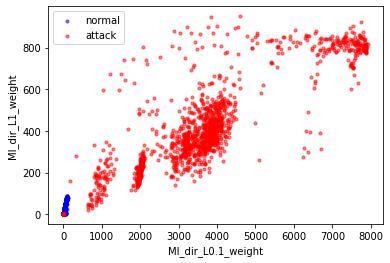

In [4]:
plot_n = 2000
atk = df_attack.sample(n=plot_n, random_state=76)
nrm = x_train.sample(n=plot_n, random_state=42)

fig, ax1 = plt.subplots()

ax1.scatter(nrm['MI_dir_L0.1_weight'],nrm['MI_dir_L1_weight'],10,c='blue', label='normal',alpha=0.5)
ax1.scatter(atk['MI_dir_L0.1_weight'],atk['MI_dir_L1_weight'],10,c='red',label='attack',alpha=0.5)

plt.xlabel('MI_dir_L0.1_weight')
plt.ylabel('MI_dir_L1_weight')

plt.legend()
plt.show()

In [5]:
classes = ['benign','malicious']
scored = []
indices = {}
shps = {}

#classifying benign as true and attack as false
for cl in classes:
    indices[cl] = df_ben['class'] == cl    
    shps[cl] =  df_ben[indices[cl]].shape[0]
        
for col in df_ben.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = df_ben[col].mean()
    
    for cl in classes:
        num += (shps[cl] / df_ben.shape[0]) * (m - df_ben[indices[cl]][col].mean())**2
        den += (shps[cl] / df_ben.shape[0]) * df_ben[indices[cl]][col].var()
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:5]

[{'feature': 'HH_jit_L0.01_mean', 'score': 0.8100151319652277},
 {'feature': 'HH_jit_L0.1_mean', 'score': 0.8052717647117524},
 {'feature': 'HH_jit_L1_mean', 'score': 0.7703158571117954},
 {'feature': 'HH_jit_L5_mean', 'score': 0.7627209177162049},
 {'feature': 'HH_jit_L3_mean', 'score': 0.7625725671879852}]

### Predicting Anomaly

In [6]:
class AnomalyModel:
    #initialize model
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    #predict the outcome using treshold
    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)
    
    #scale the classes
    def scale_predict_classes(self, x):
        x = self.scaler.transform(x)
        y_pred = self.predict(x)
        classes_arr = []
        for e in y_pred:
            el = [0,0]
            el[e] = 1
            classes_arr.append(el)
        print(classes_arr)

        return np.array(classes_arr)

### Model creation - Deep autoencoder

In [7]:
def deep_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.25 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

### Fit model

In [8]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = deep_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly{top_n_features}.h5",monitor='val_loss',save_best_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs,
                    validation_data=(X_opt, X_opt),
                    verbose=1,
                    callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary())    

Epoch 1/100
648/648 [==============================] - 6s 5ms/step - loss: 0.3310 - val_loss: 0.0787
Epoch 2/100
648/648 [==============================] - 2s 3ms/step - loss: 0.0652 - val_loss: 0.0536
Epoch 3/100
648/648 [==============================] - 2s 3ms/step - loss: 0.0435 - val_loss: 0.0376
Epoch 4/100
648/648 [==============================] - 2s 3ms/step - loss: 0.0346 - val_loss: 0.0334
Epoch 5/100
648/648 [==============================] - 2s 3ms/step - loss: 0.0307 - val_loss: 0.0234
Epoch 6/100
648/648 [==============================] - 2s 3ms/step - loss: 0.0204 - val_loss: 0.0205
Epoch 7/100
648/648 [==============================] - 2s 3ms/step - loss: 0.0227 - val_loss: 0.0182
Epoch 8/100
648/648 [==============================] - 2s 3ms/step - loss: 0.0205 - val_loss: 0.0192
Epoch 9/100
648/648 [==============================] - 2s 4ms/step - loss: 0.0192 - val_loss: 0.0164
Epoch 10/100
648/648 [==============================] - 2s 3ms/step - loss: 0.0146 - val_lo

### Predict train dataset

In [9]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        
        #accs.append({'acc': acc, 'n': top_n_features, 'cm': confusion_matrix(Y_test, Y_pred)})

Selecting n------------------
For n 1
Accuracy
0.8581909450719182
Precision 0.9867506231142594
Recall 0.7261318660102326
Confusion Matrix [[20516   202]
 [ 5674 15044]]
For n 2
Accuracy
0.8602181677768125
Precision 0.9922173855691861
Recall 0.7261318660102326
Confusion Matrix [[20600   118]
 [ 5674 15044]]
For n 3
Accuracy
0.8608939086784438
Precision 0.9940531254129774
Recall 0.7261318660102326
Confusion Matrix [[20628    90]
 [ 5674 15044]]
For n 4
Accuracy
0.8613041799401486
Precision 0.9951709995369452
Recall 0.7261318660102326
Confusion Matrix [[20645    73]
 [ 5674 15044]]
For n 5
Accuracy
0.8615455159764456
Precision 0.9958297477990335
Recall 0.7261318660102326
Confusion Matrix [[20655    63]
 [ 5674 15044]]
For n 6
Accuracy
0.8618592528236316
Precision 0.996687425467073
Recall 0.7261318660102326
Confusion Matrix [[20668    50]
 [ 5674 15044]]
For n 7
Accuracy
0.8619799208417801
Precision 0.9970176950096097
Recall 0.7261318660102326
Confusion Matrix [[20673    45]
 [ 5674 15044]

### Test data

In [10]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
deep_tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
deep_acc = accuracy_score(Y_test, Y_pred)
deep_precision = precision_score(Y_test, Y_pred)
deep_recall = recall_score(Y_test, Y_pred)
deep_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',deep_acc)
print('Precision ',deep_precision)
print("Recall",deep_recall)
print('Confusion Matrix',deep_cm)
   
#print(accs)

Test-----------------
best n 25
Treshold  1.578039503722731
Accuracy  0.8619316536345207
Precision  0.9996002398560864
Recall 0.7241529105125978
Confusion Matrix [[20712     6]
 [ 5715 15003]]


### Variational Autoencoder

In [11]:
def vae_model(input_dim):
    original_dim = input_dim
    intermediate_dim = 64
    latent_dim = 2

    inputs = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    from keras import backend as K

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling)([z_mean, z_log_sigma])

    # Create encoder
    encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

    # Create decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    return Model(inputs, outputs, name='vae_mlp')


In [12]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = vae_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_vae.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
648/648 [==============================] - 3s 3ms/step - loss: 0.7493 - val_loss: 0.5556
Epoch 2/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5603 - val_loss: 0.5428
Epoch 3/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5356 - val_loss: 0.5415
Epoch 4/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5600 - val_loss: 0.5404
Epoch 5/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5748 - val_loss: 0.5388
Epoch 6/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5600 - val_loss: 0.5370
Epoch 7/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5713 - val_loss: 0.5362
Epoch 8/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5533 - val_loss: 0.5355
Epoch 9/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5524 - val_loss: 0.5355
Epoch 10/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5587 - val_lo

### Train

In [13]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.9898397528718988
Precision 0.9800842045508302
Recall 1.0
Confusion Matrix [[20297   421]
 [    0 20718]]
For n 2
Accuracy
0.9919393763876823
Precision 0.9842725458519433
Recall 0.9998551983782218
Confusion Matrix [[20387   331]
 [    3 20715]]
For n 3
Accuracy
0.9936769958490201
Precision 0.9876513778964432
Recall 0.9998551983782218
Confusion Matrix [[20459   259]
 [    3 20715]]
For n 4
Accuracy
0.9979003764842166
Precision 0.9960567444097139
Recall 0.999758663963703
Confusion Matrix [[20636    82]
 [    5 20713]]
For n 5
Accuracy
0.9979969108987354
Precision 0.9962483767014574
Recall 0.999758663963703
Confusion Matrix [[20640    78]
 [    5 20713]]
For n 6
Accuracy
0.9980934453132542
Precision 0.9964400827440227
Recall 0.999758663963703
Confusion Matrix [[20644    74]
 [    5 20713]]
For n 7
Accuracy
0.9981417125205135
Precision 0.996583746331136
Recall 0.9997103967564437
Confusion Matrix [[20647    71]
 [    6 20712]]
For n 8
Accuracy

### Test

In [14]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
vae_acc = accuracy_score(Y_test, Y_pred)
vae_precision = precision_score(Y_test, Y_pred)
vae_recall = recall_score(Y_test, Y_pred)
vae_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',vae_acc)
print('Precision ',vae_precision)
print("Recall",vae_recall)
print('Confusion Matrix',vae_cm)

Test-----------------
best n 14
Treshold  21.932330019647857
Accuracy  0.998503716574959
Precision  0.9973514398536069
Recall 0.9996621295491843
Confusion Matrix [[20663    55]
 [    7 20711]]


### Undercomplete Autoencoder

In [15]:
def uc_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(15, activation='relu')(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [16]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = uc_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_undercomplete.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
648/648 [==============================] - 3s 4ms/step - loss: 0.7740 - val_loss: 0.5488
Epoch 2/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5512 - val_loss: 0.5362
Epoch 3/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5470 - val_loss: 0.5309
Epoch 4/100
648/648 [==============================] - 2s 4ms/step - loss: 0.5490 - val_loss: 0.5279
Epoch 5/100
648/648 [==============================] - 2s 4ms/step - loss: 0.5408 - val_loss: 0.5268
Epoch 6/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5428 - val_loss: 0.5259
Epoch 7/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5487 - val_loss: 0.5254
Epoch 8/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5469 - val_loss: 0.5250
Epoch 9/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5497 - val_loss: 0.5248
Epoch 10/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5579 - val_lo

In [17]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.9898397528718988
Precision 0.9800842045508302
Recall 1.0
Confusion Matrix [[20297   421]
 [    0 20718]]
For n 2
Accuracy
0.9919393763876823
Precision 0.9842725458519433
Recall 0.9998551983782218
Confusion Matrix [[20387   331]
 [    3 20715]]
For n 3
Accuracy
0.9935563278308717
Precision 0.9874624588835391
Recall 0.9998069311709624
Confusion Matrix [[20455   263]
 [    4 20714]]
For n 4
Accuracy
0.9979727772951057
Precision 0.9962004617160446
Recall 0.999758663963703
Confusion Matrix [[20639    79]
 [    5 20713]]
For n 5
Accuracy
0.9979969108987354
Precision 0.9962483767014574
Recall 0.999758663963703
Confusion Matrix [[20640    78]
 [    5 20713]]
For n 6
Accuracy
0.9980693117096244
Precision 0.99643991147888
Recall 0.9997103967564437
Confusion Matrix [[20644    74]
 [    6 20712]]
For n 7
Accuracy
0.9981658461241433
Precision 0.9966317005100568
Recall 0.9997103967564437
Confusion Matrix [[20648    70]
 [    6 20712]]
For n 8
Accuracy

In [18]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
uc_acc = accuracy_score(Y_test, Y_pred)
uc_precision = precision_score(Y_test, Y_pred)
uc_recall = recall_score(Y_test, Y_pred)
uc_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',uc_acc)
print('Precision ',uc_precision)
print("Recall",uc_recall)
print('Confusion Matrix',uc_cm)

Test-----------------
best n 14
Treshold  21.84994911197151
Accuracy  0.998503716574959
Precision  0.9973514398536069
Recall 0.9996621295491843
Confusion Matrix [[20663    55]
 [    7 20711]]


### Sparse Autoencoder

In [19]:
def sparse_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(200, activation='relu',
                activity_regularizer=regularizers.l1(10e-6))(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [20]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = sparse_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
648/648 [==============================] - 3s 4ms/step - loss: 0.6424 - val_loss: 0.5300
Epoch 2/100
648/648 [==============================] - 3s 5ms/step - loss: 0.5368 - val_loss: 0.5266
Epoch 3/100
648/648 [==============================] - 3s 4ms/step - loss: 0.5298 - val_loss: 0.5255
Epoch 4/100
648/648 [==============================] - 2s 4ms/step - loss: 0.5580 - val_loss: 0.5249
Epoch 5/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5456 - val_loss: 0.5245
Epoch 6/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5318 - val_loss: 0.5241
Epoch 7/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5296 - val_loss: 0.5239
Epoch 8/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5278 - val_loss: 0.5236
Epoch 9/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5529 - val_loss: 0.5235
Epoch 10/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5399 - val_lo

In [21]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.9899604208900473
Precision 0.9803160783571496
Recall 1.0
Confusion Matrix [[20302   416]
 [    0 20718]]
For n 2
Accuracy
0.9919876435949416
Precision 0.9843660900969398
Recall 0.9998551983782218
Confusion Matrix [[20389   329]
 [    3 20715]]
For n 3
Accuracy
0.9938217974707984
Precision 0.9879339946585273
Recall 0.9998551983782218
Confusion Matrix [[20465   253]
 [    3 20715]]
For n 4
Accuracy
0.9979727772951057
Precision 0.9962004617160446
Recall 0.999758663963703
Confusion Matrix [[20639    79]
 [    5 20713]]
For n 5
Accuracy
0.9979969108987354
Precision 0.9962483767014574
Recall 0.999758663963703
Confusion Matrix [[20640    78]
 [    5 20713]]
For n 6
Accuracy
0.9980934453132542
Precision 0.9964400827440227
Recall 0.999758663963703
Confusion Matrix [[20644    74]
 [    5 20713]]
For n 7
Accuracy
0.9981658461241433
Precision 0.9966317005100568
Recall 0.9997103967564437
Confusion Matrix [[20648    70]
 [    6 20712]]
For n 8
Accurac

In [22]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
sparse_acc = accuracy_score(Y_test, Y_pred)
sparse_precision = precision_score(Y_test, Y_pred)
sparse_recall = recall_score(Y_test, Y_pred)
sparse_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',sparse_acc)
print('Precision ',sparse_precision)
print("Recall",sparse_recall)
print('Confusion Matrix',sparse_cm)

Test-----------------
best n 14
Treshold  22.015404721704265
Accuracy  0.998503716574959
Precision  0.9973514398536069
Recall 0.9996621295491843
Confusion Matrix [[20663    55]
 [    7 20711]]


### Denoising Autoencoder

In [23]:
def denoise_model(input_dim):
    input_size = input_dim
    hidden_size = 44
    code_size = 5

    input_img = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size, activation='relu')(input_img)
    code = Dense(code_size, activation='relu')(hidden_1)
    hidden_2 = Dense(hidden_size, activation='relu')(code)
    output_img = Dense(input_size, activation='sigmoid')(hidden_2)

    autoencoder = Model(input_img, output_img)
    return autoencoder

In [24]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()

noise_factor = 0.5
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_opt_noisy = np.clip(x_opt_noisy, 0., 1.)

X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
#x_train_noisy = scaler.fit_transform(x_train_noisy)
#x_opt_noisy = scaler.transform(x_opt_noisy)

#call function to create the model
model = denoise_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(x_train_noisy, X_train,
                    epochs=epochs, validation_data=(x_opt_noisy, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
648/648 [==============================] - 4s 5ms/step - loss: 0.8911 - val_loss: 0.6272
Epoch 2/100
648/648 [==============================] - 3s 4ms/step - loss: 0.6542 - val_loss: 0.6161
Epoch 3/100
648/648 [==============================] - 2s 4ms/step - loss: 0.6165 - val_loss: 0.5908
Epoch 4/100
648/648 [==============================] - 2s 4ms/step - loss: 0.6033 - val_loss: 0.5879
Epoch 5/100
648/648 [==============================] - 2s 4ms/step - loss: 0.5890 - val_loss: 0.5844
Epoch 6/100
648/648 [==============================] - 2s 4ms/step - loss: 0.5937 - val_loss: 0.5831
Epoch 7/100
648/648 [==============================] - 2s 3ms/step - loss: 0.6152 - val_loss: 0.5818
Epoch 8/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5977 - val_loss: 0.5816
Epoch 9/100
648/648 [==============================] - 1s 2ms/step - loss: 0.6093 - val_loss: 0.5812
Epoch 10/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5984 - val_lo

In [25]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(x_opt_noisy)
mse = np.mean(np.power(x_opt_noisy - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
X_opt_scaled = scaler.transform(x_opt_noisy)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.5544454097885896
Precision 0.5287901990811639
Recall 1.0
Confusion Matrix [[ 2256 18462]
 [    0 20718]]
For n 2
Accuracy
0.635172313929916
Precision 0.5781498534951862
Recall 1.0
Confusion Matrix [[ 5601 15117]
 [    0 20718]]
For n 3
Accuracy
0.7308861859252823
Precision 0.6500988421349901
Recall 1.0
Confusion Matrix [[ 9567 11151]
 [    0 20718]]
For n 4
Accuracy
0.81151655565209
Precision 0.7262338754907459
Recall 1.0
Confusion Matrix [[12908  7810]
 [    0 20718]]
For n 5
Accuracy
0.870812819770248
Precision 0.794676076867017
Recall 1.0
Confusion Matrix [[15365  5353]
 [    0 20718]]
For n 6
Accuracy
0.9128052900859156
Precision 0.8515063088241338
Recall 1.0
Confusion Matrix [[17105  3613]
 [    0 20718]]
For n 7
Accuracy
0.9401245293947292
Precision 0.8930557351609983
Recall 1.0
Confusion Matrix [[18237  2481]
 [    0 20718]]
For n 8
Accuracy
0.9594555459021141
Precision 0.9249933029734798
Recall 1.0
Confusion Matrix [[19038  1680]

In [26]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(x_test_noisy, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=20)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
X_test_scaled = scaler.transform(x_test_noisy)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
denoise_acc = accuracy_score(Y_test, Y_pred)
denoise_precision = precision_score(Y_test, Y_pred)
denoise_recall = recall_score(Y_test, Y_pred)
denoise_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',denoise_acc)
print('Precision ',denoise_precision)
print("Recall",denoise_recall)
print('Confusion Matrix',denoise_cm)

Test-----------------
best n 29
Treshold  6.948382496385761
Accuracy  0.9998551983782218
Precision  0.9999517234720479
Recall 0.999758663963703
Confusion Matrix [[20717     1]
 [    5 20713]]


### Deep Neural Net

In [27]:
def dnn_model(inputs):
    model = Sequential()
    model.add(Dense(115, input_dim=inputs, activation='relu'))
    model.add(Dense(80, input_dim=inputs, activation='relu'))
    model.add(Dense(10, input_dim=inputs, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(labels.shape[1],activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', min_delta=1e-3, callbacks=[monitor], patience=5) 
    model.fit(x_train_st,y_train_st,validation_data=(x_test_st,y_test_st),
          verbose=1,epochs=100, callbacks=[es])

In [28]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 1

df_ben = x_train.copy()
df_ben['class'] = 0

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=17))

X = df_ben.drop(columns=['class'])
y = df_ben['class']

In [29]:
#split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=17)

#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [30]:
#create model
model = Sequential()
model.add(Dense(115, input_dim=115, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100

#compile and fit model
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train,y_train,epochs=epochs,batch_size=15,callbacks=[es])

end = time.time()
print("time",end-start)

Epoch 1/100
2210/2210 [==============================] - 6s 2ms/step - loss: 0.0079
Epoch 2/100
2210/2210 [==============================] - 5s 2ms/step - loss: 9.4961e-04A
Epoch 3/100
2210/2210 [==============================] - 4s 2ms/step - loss: 0.0010
Epoch 4/100
2210/2210 [==============================] - 5s 2ms/step - loss: 4.0130e-04
Epoch 5/100
2210/2210 [==============================] - 5s 2ms/step - loss: 7.5083e-04
Epoch 6/100
2210/2210 [==============================] - 5s 2ms/step - loss: 6.8843e-04
Epoch 7/100
2210/2210 [==============================] - 5s 2ms/step - loss: 0.0012
Epoch 8/100
2210/2210 [==============================] - 5s 2ms/step - loss: 7.9905e-04
Epoch 9/100
2210/2210 [==============================] - 5s 2ms/step - loss: 8.9063e-04
Epoch 10/100
2210/2210 [==============================] - 5s 2ms/step - loss: 8.3752e-04
Epoch 11/100
2210/2210 [==============================] - 5s 2ms/step - loss: 0.0011
Epoch 12/100
2210/2210 [=====================

In [31]:
predictions = model.predict(X_test)
y_pred = [round(x[0]) for x in predictions]

In [32]:
dnn_acc = accuracy_score(y_test, y_pred)
dnn_precision = precision_score(y_test, y_pred)
dnn_recall = recall_score(y_test, y_pred)
dnn_cm = confusion_matrix(y_test, y_pred)
print('Accuracy ',dnn_acc)
print('Precision ',dnn_precision)
print("Recall",dnn_recall)
print('Confusion Matrix',dnn_cm)

Accuracy  0.9987934362934363
Precision  0.9978406909788867
Recall 0.9997596153846153
Confusion Matrix [[4119    9]
 [   1 4159]]


### Model comparison

In [33]:
print("Provision PT_737E Security Camera")
model_summary = pd.DataFrame({'Model' :['Deep AutoEncoder',"Variational AutoEncoder","Sparse AutoEncoder","Undercomplete Autoencoder","Denoising Autoendoer"],
                             'Accuracy':[deep_acc,vae_acc,sparse_acc,uc_acc,denoise_acc],
                             'Precision':[deep_precision,vae_precision,sparse_precision,uc_precision,denoise_precision],
                             'Recall':[deep_recall,vae_recall,sparse_recall,uc_recall,denoise_recall],
                             'CM':[deep_cm,vae_cm,sparse_cm,uc_cm, denoise_cm]})
model_summary.sort_values(by='Accuracy', ascending=True)

Provision PT_737E Security Camera


,Model,Accuracy,Precision,Recall,CM
0,Deep AutoEncoder,0.861932,0.999600,0.724153,"[[20712, 6], [5715, 15003]]"
1,Variational AutoEncoder,0.998504,0.997351,0.999662,"[[20663, 55], [7, 20711]]"
2,Sparse AutoEncoder,0.998504,0.997351,0.999662,"[[20663, 55], [7, 20711]]"
3,Undercomplete Autoencoder,0.998504,0.997351,0.999662,"[[20663, 55], [7, 20711]]"
4,Denoising Autoendoer,0.999855,0.999952,0.999759,"[[20717, 1], [5, 20713]]"
